# Class activation Map with pyTorch.

Метод Class Activation Maps (CAM) один из инструментов, который помогает сделать модели более понятными. CAM позволяет визуализировать, какие части входных данных (в основном изображения) наиболее значимы для конкретного предсказания модели. Как и другие карты активации, метод выделяет области, которые влияют на решение модели, предоставляя таким образом визуальные объяснения.

В этой практике мы изучим, как применять метод CAM для интерпретации моделей глубокого обучения, в частности, сверточных нейронных сетей (CNN), а также посмотрим на примение CAM для выделения контрфактических областей.

**Цели практики:**

- Понять реализацию метода Class Activation Maps.
- Научиться применять этот метод для визуализации значимых областей входных данных.
- Исследовать примеры использования CAM для интерпретации предсказаний модели.
- Рассмотреть примение CAM для выделения контрфактических областей.
<a href="https://ibb.co/9yCzwLG"><img src="https://i.ibb.co/3SLGfqk/hartono-creative-studio-1g-W-pze-XX2-E-unsplash.jpg" alt="hartono-creative-studio-1g-W-pze-XX2-E-unsplash" border="0"></a>

In [ ]:
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import torchvision.models as models
from torchvision import transforms

from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import torch
import urllib
import requests
import numpy as np
from io import BytesIO

import numpy as np
import skimage.transform
from torchvision.models import resnet50, ResNet50_Weights, vgg16, VGG16_Weights

Загрузим изображение, с которым будем работать.

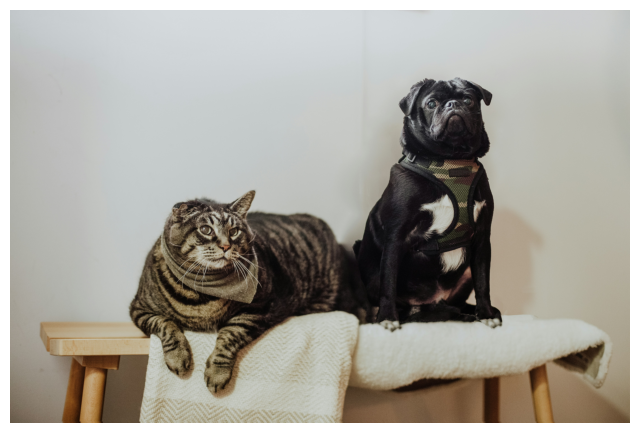

In [ ]:
# Загрузка изображения
url = 'https://github.com/aiedu-courses/all_datasets/blob/main/images/cat_and_dog.jpg?raw=true'

image_bytes = requests.get(url).content
image = Image.open(BytesIO(image_bytes)) # Снова рассмотрим конкретный пример x_0


plt.figure(figsize=(8,10))
plt.axis('off')
plt.imshow(image);

Определим два pipeline:

- для предобработки изображения перед подачей модели (значения для нормализации возьмем те же, что и в прошлой практике, поскольку снова будем работать с сетью, обученной на imagenet)

- для сохранения оригинального изображения, поскольку мы будем сравнивать карту активации с оригиналом

In [ ]:
#1
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
   transforms.Resize((224,224)),
])

#2
display = transforms.Compose([transforms.Resize((224,224))])

## **Построение Class Activation Map.**

Вспомним процесс построения CAM из урока. Для него нам нужны:

-  Карты активации сверточного слоя (обычно последнего). $A^k \in R^{u\times v}$, $k=1,2 ... n$
- Веса, отвечающие за прогноз класса $c$ ($w^c)$.

При данных переменных, карта активации записывается как:
$$M_c(x, y) = \sum_k w^c_kA_k $$ — class activation map для класса $c$.

​Как получить карты активации последнего слоя $A_k$? В этом нам помогут ***Hooks.***

И так, нам необходимо извлечь из модели карту активаций последнего слоя.

В решении задачи нам поможет применение "хуков"(*Hooks*) — дословно — "крючков" или "перехватчиков".

Понятие *Hook* не является специальным для DL и встречается также в других областях программирования.

**В общем определении можно сказать так:**

**Hooks** —  это функции, которые автоматически выполняются после определенного события.

В контексте pyTorch хуки — это механизм для получения информации о поведении нейронных сетей во время прямого и обратного прохода. Они позволяют прикреплять пользовательские функции (которые и являются хуками) к тензорам (tensors) и модулям (`torch.nn.Module`) нейронной сети, позволяя отслеживать, изменять или записывать различные аспекты графа вычислений.

Мы будем использовать Hook для получения карты активации с последнего сверточного слоя, но прежде рассмотрим простой пример.

**Рассмотрим функцию:** $$f=u^2=(a^2+b)^2,$$
при $a=2, b=3$.

Совершим *Forward pass*  просто вычислим функцию при заданны $a$ и $b$:

$f=u^2=(a^2+b)^2= (2^2+3)^2 = 49$

После, вычислим *Backward pass*. Напомним, что его вычисление происходит по правилу "цеопчки" ([chain rule](https://en.wikipedia.org/wiki/Chain_rule)).

$\frac{\partial f}{\partial f}=1$


$\frac{\partial f}{\partial a} = \frac{\partial f}{\partial f}\frac{\partial f}{\partial u}\frac{\partial u}{\partial a} = 1*2u*2a=1*2*7*2*2=14*4=56$

$\frac{\partial f}{\partial b} = \frac{\partial f}{\partial f}\frac{\partial f}{\partial u}\frac{\partial u}{\partial b} = 1*2u*1=2*7*1=14=14$

Чтобв сохранить градиенты всех параметров функции используем метод `.retain_grad()`. По умолчанию PyTorch теряет градиенты для промежуточных тензоров, чтобы сэкономить память. Метод `.retain_grad()` позволяет явно указать, что градиенты должны сохраняться и для промежуточных тензоров.

In [ ]:
# Зададим два тензора и третий, как функцию от них
a = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(3.0, requires_grad=True)
c = (a**2 + b)**2

c.retain_grad() # указываем pyTorch сохранять градиенты для промежуточных тензоров
c.backward()

print(c)

print(a.grad)
print(b.grad)
print(c.grad)

Теперь прикрепим к обратному проходу нашего графа простой "хук". Будем прибавлять по 2 к получаемому градиенту.

In [ ]:
# Зададим фунцию-хук
def hook(grad):
  return grad + 2

a = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(3.0, requires_grad=True)
c = (a**2 + b)**2

c.retain_grad()
c.register_hook(hook)

c.backward()

print(c)

print(a.grad)
print(# Ваш код здесь)
print(c.grad)

tensor(49., grad_fn=<PowBackward0>)
tensor(168.)
tensor(42.)
tensor(3.)


**Quiz** Чему равен градиент параметра $b$, после добавления хука?

**Как получаются выходные значения.**

Рассмотрим ту жефункцию $f=u^2=(a^2+b)^2$, при $a=2, b=3$

**Forward pass:**

$f=u^2=(a^2+b)^2= (2^2+3)^2 = 49$

**Backward pass + Hook:**

$\frac{\partial f}{\partial f}=1 + 2=3$


$\frac{\partial f}{\partial a} = \frac{\partial f}{\partial f}\frac{\partial f}{\partial u}\frac{\partial u}{\partial a} = 3*2u*2a=3*2*7*2*2=3*14*4=168$




#### **Hook для forward pass**



Теперь применим Hook для forward pass рассматриваемой модели. Для удобства, оформим **Hook** в виде класса.

In [ ]:
class Hook():

    def __init__(self, m):
      self.hook = m.register_forward_hook(self.hook_func) #цепляемся за forward проход слоя m, переданного при инициализации

    def hook_func(self, module, input, output):
      self.features = ((output.cpu()).data).numpy() #получаем output слоя и лепим в numpy массив

    def remove(self):
      self.hook.remove()

Загрузим модель. Будем использовать ResNet50, обученную на imagenet.

In [ ]:
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1) # загрузка модели
model.eval();

И подготовим изображение для подачи нейронной сети.

In [ ]:
preprocessed_image = preprocess(image).unsqueeze(0) # Предобработка и добавление размерности батча

Теперь, прикрепим наш хук. Для этого найдем и извлечем последний слой.

**Quiz** Посмотрите на архитектуру модели. Как называется последний слой **перед** Average Pooling?

In [ ]:
#model #layer4

Теперь извлечем этот слой и прикрепим к нему хук.

In [ ]:
final_layer = model._modules.get('layer4')
act_maps = Hook(final_layer) # цепляемся за layer 4

In [ ]:
vgg_final_layer = vgg.features[-1]
vgg_act_maps = Hook(vgg_final_layer)


Сейчас наш **Hook** был инициализирован, но ничего не перехватил. Чтобы получить интересующую нас карту, делаем Forward pass.

Также, поскольку последний слой модели был просто линейным слоем, мы далее пропускаем значения через softmax и извлекаем вероятности.

In [ ]:
prediction = model(preprocessed_image) #forward pass
pred_prob = F.softmax(prediction, -1).data.squeeze()

Удалим Hook так как он нам больше не нужен.

In [ ]:
act_maps.remove()

**Quiz** Чему соответствует выход последнего сверточного слоя карта активации на последнем слое до AdaptiveAvgPool?

**Подсказка:** вам может помочь использование `torch.summary(model, input_shape)`

In [ ]:
from torchsummary import summary
# Ваш код здесь

Теперь небходимо извлечь веса, *связанные с нашим прогнозом*. Для этого нам понадобятся:
- сам прогноз;
- параметры самого последнего (полносвязного) слоя;

In [ ]:
#Получаем прогноз

idx = topk(pred_prob, 1)[1].int()[0]

print(f'Прогноз модели класс № {idx}')

Прогноз модели класс № 179


179 класс соответвует Staffordshire bull terrier.  Похоже, модель не ошиблась! Посмотрим, кто вошел в топ-3.

In [ ]:
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
urllib.request.urlretrieve(url, "imagenet_classes.txt")

with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [ ]:
for i in topk(pred_prob, 10)[1]:
  print(categories[i])

Staffordshire bullterrier
pug
French bulldog
American Staffordshire terrier
bull mastiff
tabby
Brabancon griffon
Boston bull
tiger cat
muzzle


Извлечем параметры самого последнего слоя. Обратите внимание, что их размерность равна (`num_classes`, `num_in_features`) поскольку каждому классу соответствует свой набор весов, который связывает входные карты признаков с этим классом.

In [ ]:
last_layer_params = list(model._modules.get('fc').parameters())[0]

In [ ]:
weights_interested = model.fc.weight[245, :]  #w^c_k извлечем интересующий нас класс
weights_interested = weights_interested.cpu().data.numpy()

Откуда по формуле
$$M_c(x, y) = \sum_k w^c_kA_k $$

​

In [ ]:
cam = weights_interested.dot(act_maps.features.reshape((2048, 7*7))) #поэлементное произведение
print(cam.shape)

(49,)


И преобразуем карту признаков в читаемый вид.

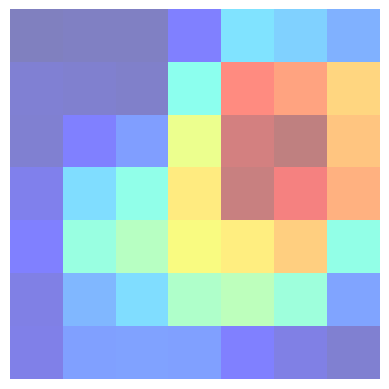

In [ ]:
cam = cam.reshape((7,7))

plt.imshow(cam, alpha=0.5, cmap='jet');
plt.axis('off');

Чтобы наложить карту признаков на изображение, нужно привести её к соответствующем размеру. А именно от $7\times 7$ к $224\times 224$. Это можно сделать при помощи `torch.nn.Functional.interpolate()`.

(-0.5, 223.5, 223.5, -0.5)

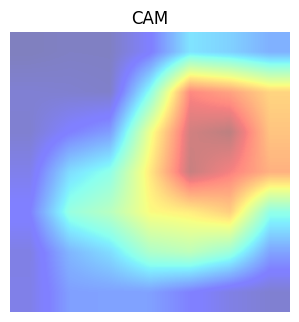

In [ ]:
cam_tensor = torch.from_numpy(cam).float().unsqueeze(0).unsqueeze(0)  # Преобразовываем обратно в тензор
interpol = F.interpolate(cam_tensor, (224, 224), mode="bilinear").squeeze(0).squeeze(0) # Интерполируем карту на изображение

plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(interpol, alpha=0.5, cmap='jet');
plt.title('CAM')
plt.axis('off')

В завершение наведём красоту и отобразим результат.

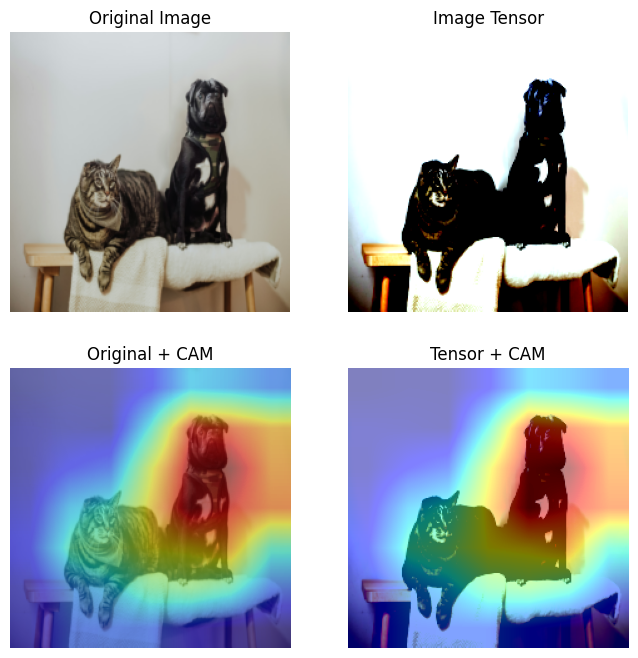

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(display(image))
plt.axis('off')
plt.title('Original Image')

plt.subplot(222)
imshow(preprocessed_image.squeeze(0).permute(1, 2, 0))
plt.axis('off')
plt.title('Image Tensor')


plt.subplot(223)
imshow(display(image))
plt.axis('off')
imshow(interpol, alpha=0.5, cmap='jet');
plt.title('Original + CAM')


plt.subplot(224)
imshow(preprocessed_image.squeeze(0).permute(1, 2, 0))
plt.axis('off')
imshow(interpol, alpha=0.5, cmap='jet')
plt.title('Tensor + CAM');

## Контрфактические области с  CAM.

В теоретической части мы показали, что взятие антиградиента (всех карт активации со знаком "-") может помогать находить контрфактические области. В контексте CV это значит, что мы можем видить области, акцент внимания на которые приведет другому прогнозу. Однако, это не всегда так и просто отрицательная карта активаций может оказаться бесполезной.

Например, если мы возьмем карты активации класса Staffordshire bullterrier (спрогнозированного), то получим просто откражение области.

(-0.5, 223.5, 223.5, -0.5)

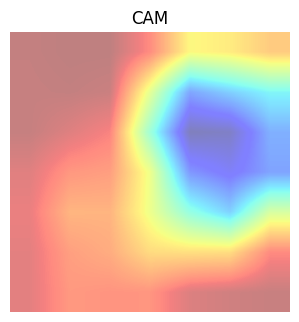

In [ ]:
#Убедитесь в этом, исполнив код

weights_interested = model.fc.weight[idx, :]  #w^c_k извлечем интересующий нас класс
weights_interested = weights_interested.cpu().data.numpy()

negative_cam = weights_interested.dot(-act_maps.features.reshape((2048, 7*7))) #поэлементное произведение со знаком "-"

negative_cam = negative_cam.reshape((7,7))

negative_cam_tensor = torch.from_numpy(negative_cam).float().unsqueeze(0).unsqueeze(0)  # Add two dimensions: channel and batch
interpol = F.interpolate(negative_cam_tensor, (224, 224), mode="bilinear")

plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(interpol.squeeze(0).squeeze(0), alpha=0.5, cmap='jet');
plt.title('CAM')
plt.axis('off')

Однако, это не значит, что сама теория не работает. Рассмотрим, котрфактическое объяснение к классу 283 - Persian cat.

(-0.5, 223.5, 223.5, -0.5)

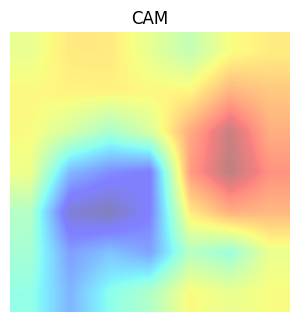

In [ ]:
cat_weights_interested = model.fc.weight[283, :]  #w^c_k извлечем интересующий нас класс
cat_weights_interested = cat_weights_interested.cpu().data.numpy()

negative_cat_cam = cat_weights_interested.dot(-act_maps.features.reshape((2048, 7*7))) #поэлементное произведение со знаком "-"

negative_cat_cam = negative_cat_cam.reshape((7,7))

negative_cat_cam_tensor = torch.from_numpy(negative_cat_cam).float().unsqueeze(0).unsqueeze(0)  # Add two dimensions: channel and batch
interpol = F.interpolate(negative_cat_cam_tensor, (224, 224), mode="bilinear")

plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(interpol.squeeze(0).squeeze(0), alpha=0.5, cmap='jet');
plt.title('CAM')
plt.axis('off')

Работа теории — контрфактический объект к кошке — собака! Какой из этого вывод:

- теоретические свойства методов explainable AI не являются устойчивыми, однако их знаниние может помогать извлекать из модели дополнительный инсайты.